# Advanced Xarray


*This material is adapted from the [Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html), from Ryan Abernathey (Columbia University)*.


In this notebook, we cover some more advanced aspects of `Xarray`.

## Groupby

`Xarray` copies Pandas' very useful groupby functionality, enabling the "split / apply / combine" workflow on xarray DataArrays and Datasets. In the first part of the notebook, we will learn to use groupby by analyzing sea-surface temperature data.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

plt.rcParams['figure.figsize'] = (6,5)

First we load a dataset. We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) product, a widely used and trusted gridded compilation of of historical data going back to 1854.

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [41]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1960', '2018')).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

Let's do some basic visualizations of the data, just to make sure it looks reasonable.

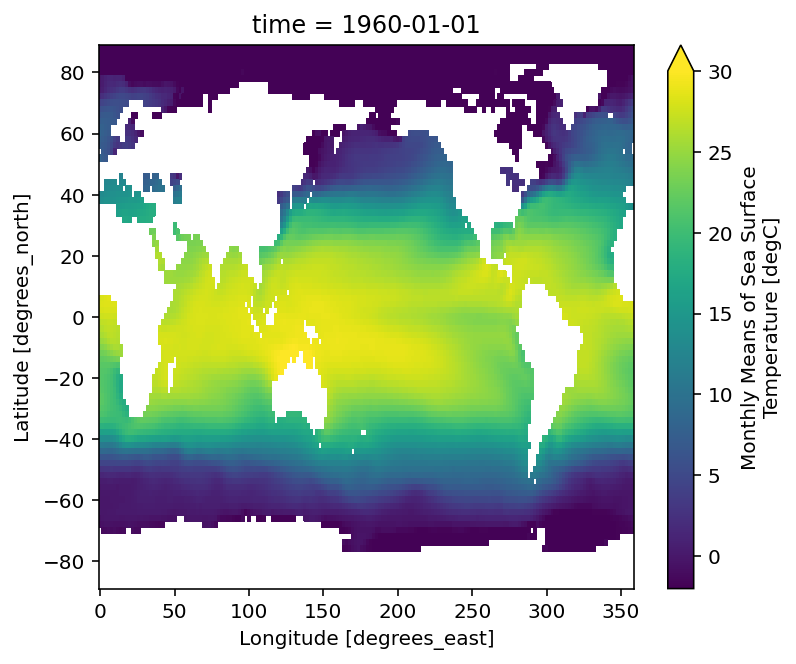

In [42]:
ds.sst[0].plot(vmin=-2, vmax=30)

Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [4]:
ds.time

<xarray.DataArray 'time' (time: 708)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80750.]
    _ChunkSizes:      1

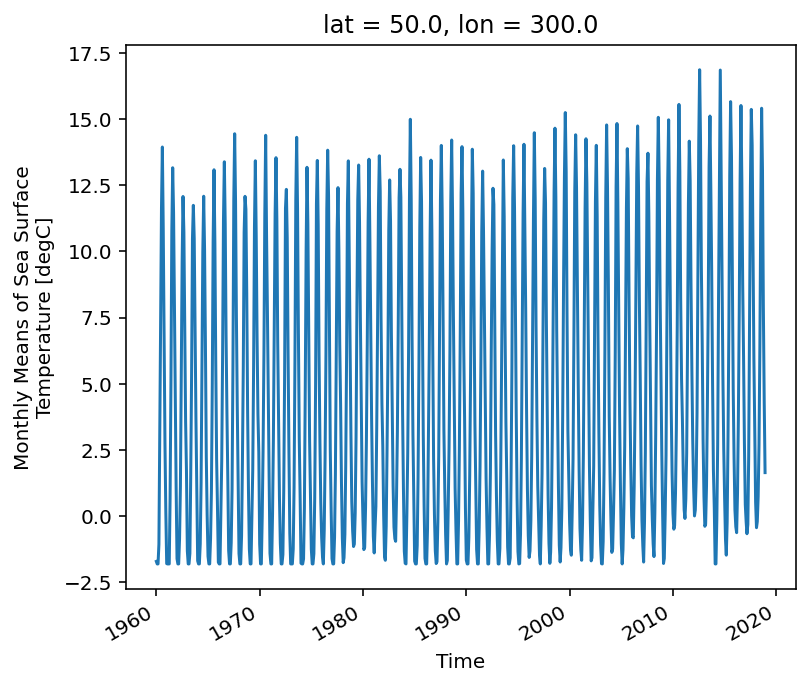

In [5]:
ds.sst.sel(lon=300, lat=50).plot()

As we can see from the plot, the timeseries at any one point is totally dominated by the seasonal cycle. We would like to remove this seasonal cycle (called the "climatology") in order to better see the long-term variaitions in temperature. We will accomplish this using **groupby**.

The syntax of `Xarray`'s `groupby` is almost identical to `Pandas`.

In [6]:
help(ds.groupby)

Help on method groupby in module xarray.core.common:

groupby(group, squeeze: bool = True, restore_coord_dims: bool = None) method of xarray.core.dataset.Dataset instance
    Returns a GroupBy object for performing grouped operations.
    
    Parameters
    ----------
    group : str, DataArray or IndexVariable
        Array whose unique values should be used to group this array. If a
        string, must be the name of a variable contained in this dataset.
    squeeze : bool, optional
        If "group" is a dimension of any arrays in this dataset, `squeeze`
        controls whether the subarrays have a dimension of length 1 along
        that dimension or if the dimension is squeezed out.
    restore_coord_dims : bool, optional
        If True, also restore the dimension order of multi-dimensional
        coordinates.
    
    Returns
    -------
    grouped
        A `GroupBy` object patterned after `pandas.GroupBy` that can be
        iterated over in the form of `(unique_value, g

### Split Step

The most important argument is `group`: this defines the unique values we will use to "split" the data for grouped analysis. We can pass either a `DataArray` or a name of a variable in the dataset. Lets first use a `DataArray`. Just like with `Pandas`, we can use the time index to extract specific components of dates and times. `Xarray` uses a special syntax for this `.dt`, called the `DatetimeAccessor`.

In [7]:
ds.time.dt

In [8]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 708)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
...
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

ds.time.dt.year

We can use these arrays in a groupby operation:

In [9]:
gb = ds.groupby(ds.time.dt.month)
gb

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. This is identical to the previous line:

In [10]:
gb = ds.groupby('time.month')
gb

DatasetGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now that the data are split, we can manually iterate over the group. The iterator returns the key (group name) and the value (the actual dataset corresponding to that group) for each group.

In [11]:
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break 
print(group_name)
group_ds

1


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the group. Like in Pandas, these calculations can either be:
- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated / transformed groups back into a single object.

The most fundamental way to apply is with the `.apply` method.

In [12]:
help(gb.apply)

Help on method apply in module xarray.core.groupby:

apply(func, args=(), shortcut=None, **kwargs) method of xarray.core.groupby.DatasetGroupBy instance
    Backward compatible implementation of ``map``
    
    See Also
    --------
    DatasetGroupBy.map



#### Aggregations

`.apply` accepts as its argument a function. We can pass an existing function:

In [13]:
gb.apply(np.mean)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 13.66 13.77 13.76 13.68 ... 13.98 13.69 13.51 13.53

Because we specified no extra arguments (like `axis`) the function was applied over all space and time dimensions. This is not what we wanted. Instead, we could define a custom function. This function takes a single argument--the group dataset--and returns a new dataset to be combined:

In [14]:
def time_mean(a):
    return a.mean(dim='time')

gb.apply(time_mean)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

Like Pandas, xarray's groupby object has many built-in aggregation operations (e.g. `mean`, `min`, `max`, `std`, etc):

In [15]:
# this does the same thing as the previous cell
ds_mm = gb.mean(dim='time')
ds_mm

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

So we did what we wanted to do: calculate the climatology at every point in the dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_

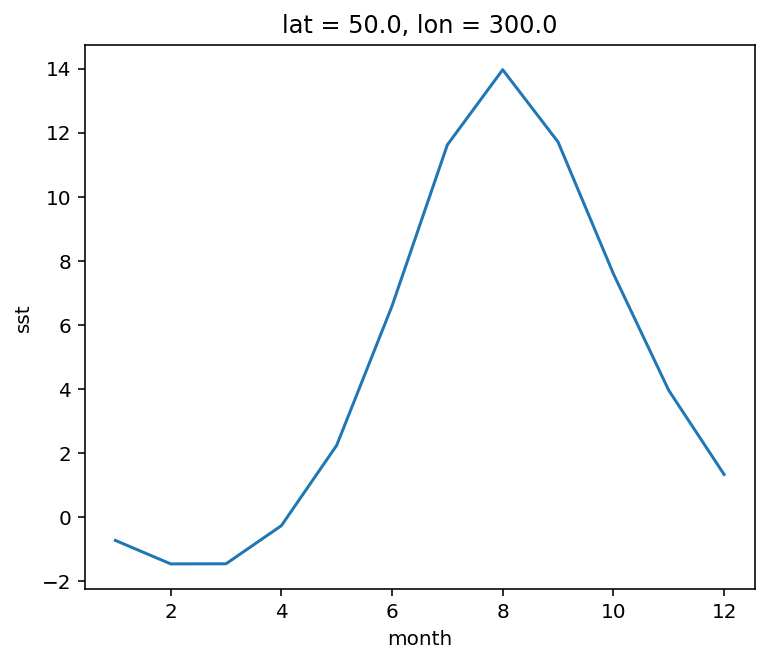

In [16]:
ds_mm.sst.sel(lon=300, lat=50).plot()

_Zonal Mean Climatolgoy_

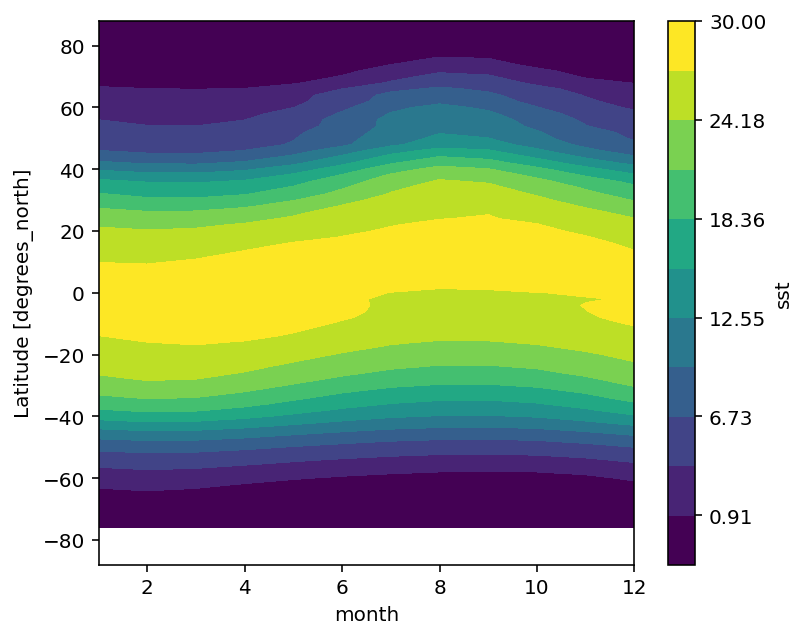

In [17]:
ds_mm.sst.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30)

_Difference between January and July Climatology_

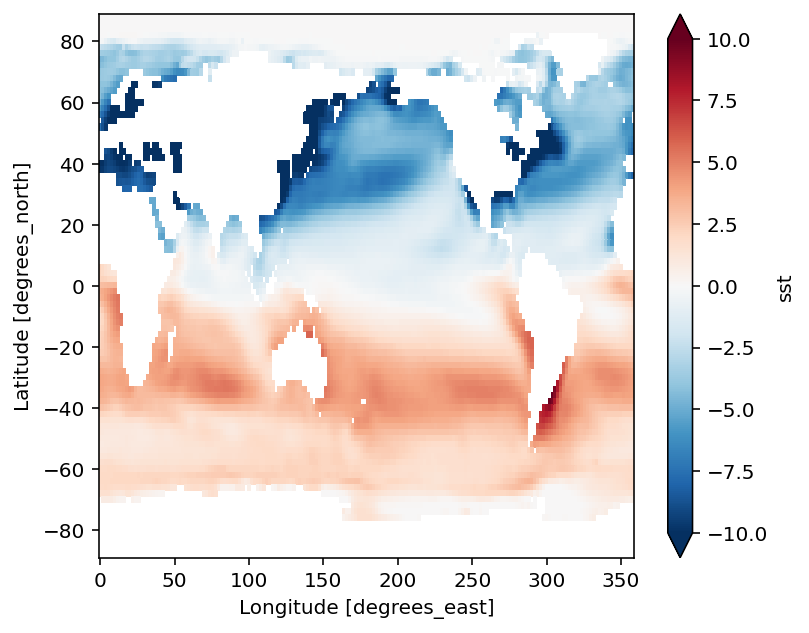

In [18]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10)

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the residual, called the _anomaly_, which is the interesting part from a climate perspective.
Removing the seasonal climatology is a perfect example of a transformation: it operates over a group, but doesn't change the size of the dataset. Here is one way to code it

In [19]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds.groupby('time.month').apply(remove_time_mean)
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

Xarray makes these sorts of transformations easy by supporting _groupby arithmetic_.
This concept is easiest explained with an example:

In [20]:
gb = ds.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

Now we can view the climate signal without the overwhelming influence of the seasonal cycle.

_Timeseries at a single point in the North Atlantic_

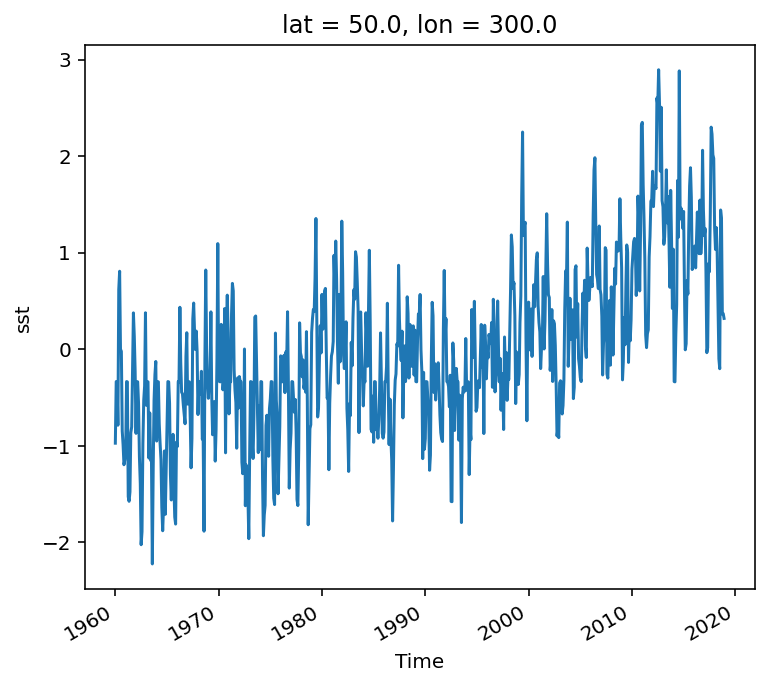

In [21]:
ds_anom.sst.sel(lon=300, lat=50).plot()

_Difference between Jan. 1 2018 and Jan. 1 1960_

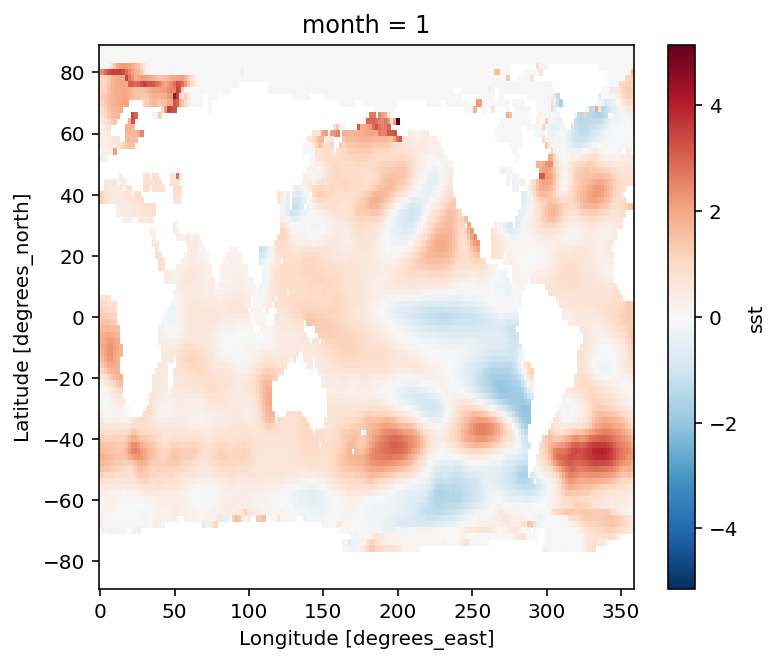

In [22]:
(ds_anom.sel(time='2018-01-01') - ds_anom.sel(time='1960-01-01')).sst.plot()

## Grouby-Related: Resample, Rolling, Coarsen

Resample in xarray is nearly identical to Pandas. It is effectively a group-by operation, and uses the same basic syntax. It can be applied only to time-index dimensions. Here we compute the five-year mean.

In [23]:
ds_anom_resample = ds_anom.resample(time='5Y').mean(dim='time')
ds_anom_resample

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 13)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float32 -0.0005707 -0.0005493 ... nan nan

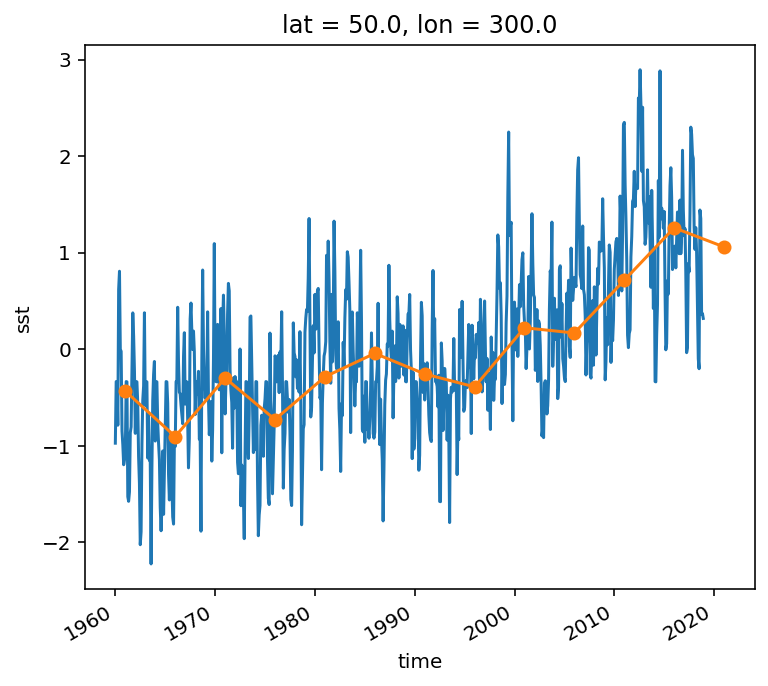

In [24]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o')

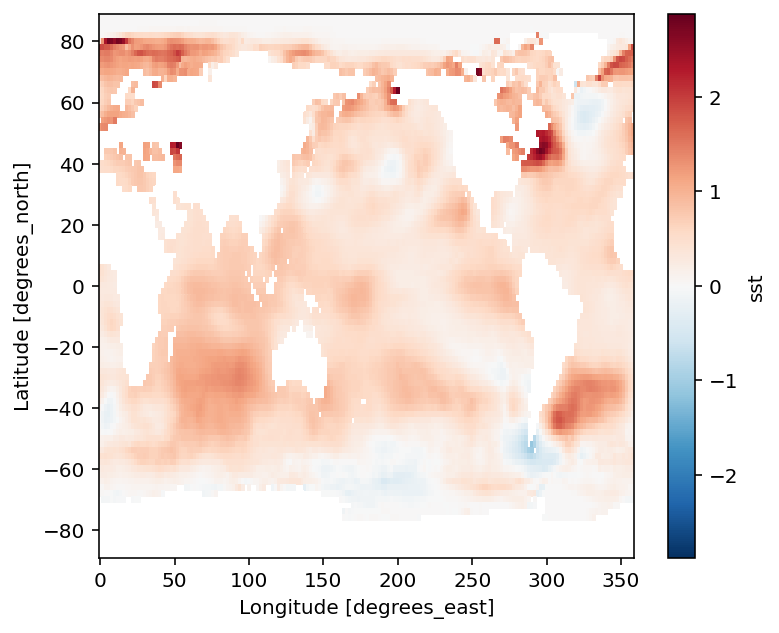

In [25]:
(ds_anom_resample.sel(time='2015-01-01', method='nearest') -
 ds_anom_resample.sel(time='1965-01-01', method='nearest')).sst.plot()

Rolling is also similar to pandas.

In [26]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

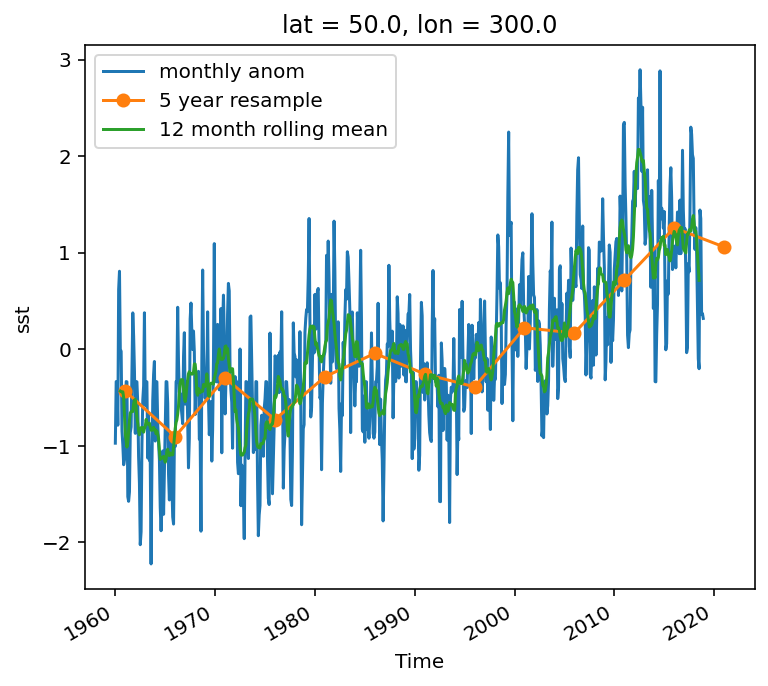

In [27]:
ds_anom.sst.sel(lon=300, lat=50).plot(label='monthly anom')
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o', label='5 year resample')
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label='12 month rolling mean')
plt.legend()

In [28]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [29]:
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin

<xarray.Dataset>
Dimensions:  (Z: 33, lat: 180, lon: 360)
Coordinates:
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    basin    (Z, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [30]:
basin_surf = basin.basin[0]
basin_surf

<xarray.DataArray 'basin' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.]], dtype=float32)
Coordinates:
    Z        float32 0.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  basin code
    units:      ids
    scale_max:  58
    CLIST:      Atlantic Ocean\nPacific Ocean \nIndian Ocean\nMediterranean S...
    valid_min:  1
    valid_max:  58
    scale_min:  1

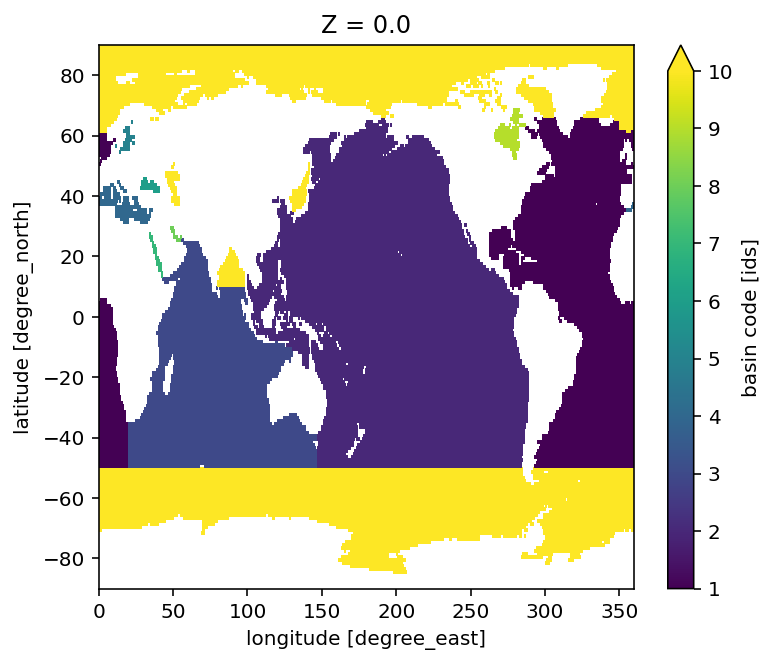

In [31]:
basin_surf.plot(vmax=10)

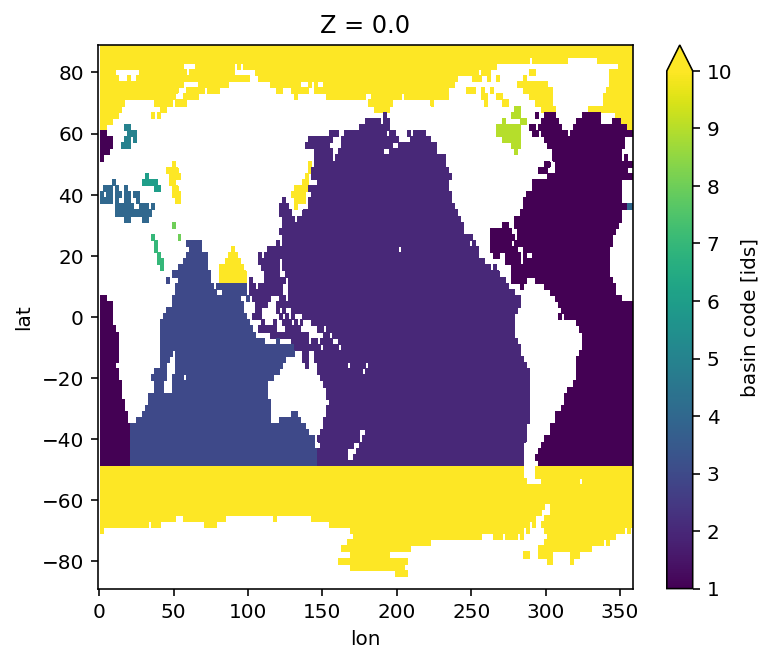

In [32]:
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
basin_surf_interp.plot(vmax=10)

In [33]:
ds.sst.groupby(basin_surf_interp).first()

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[-1.8       , -1.8       , 23.455315  , ..., -1.8       ,
         3.3971915 , 24.182198  ],
       [-1.8       , -1.8       , 23.722523  , ..., -1.8       ,
         0.03573781, 24.59657   ],
       [-1.8       , -1.8       , 24.601315  , ..., -1.8       ,
        -0.26487017, 26.234186  ],
       ...,
       [ 0.6758096 ,  6.5041866 , 29.279472  , ..., 10.920225  ,
        15.955018  , 29.419764  ],
       [-0.7937473 ,  3.0715103 , 27.608444  , ...,  5.4078865 ,
        10.673691  , 27.755806  ],
       [-1.8       , -0.06061229, 25.881489  , ...,  0.5253577 ,
         7.2676916 , 26.16315   ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [34]:
basin_mean_sst = ds_mm.sst.groupby(basin_surf_interp).mean()
basin_mean_sst

<xarray.DataArray 'sst' (month: 12, basin: 14)>
array([[18.931244  , 20.88606   , 22.068876  , 15.7806225 ,  2.9009485 ,
         8.286119  , 25.862597  , 21.052422  , -1.7988946 ,  2.5364153 ,
        -1.2113837 ,  5.99166   ,  6.69535   , 26.615591  ],
       [18.998413  , 20.938007  , 22.466644  , 15.171556  ,  1.6216687 ,
         7.475156  , 25.31563   , 20.009794  , -1.8000002 ,  2.86857   ,
        -1.2622244 ,  4.981395  ,  5.473524  , 26.889442  ],
       [19.013428  , 20.972063  , 22.608067  , 15.258743  ,  1.4993656 ,
         7.793447  , 25.649214  , 20.699417  , -1.8000002 ,  2.6315544 ,
        -1.2847868 ,  5.1045027 ,  5.522258  , 28.037973  ],
       [18.989248  , 20.968798  , 22.381023  , 16.224312  ,  3.0491576 ,
        10.017782  , 26.88303   , 23.203306  , -1.7996598 ,  2.094409  ,
        -1.2763202 ,  6.663208  ,  9.4189415 , 29.374727  ],
       [19.068415  , 21.018923  , 21.714952  , 18.613165  ,  6.4635086 ,
        14.915698  , 28.640142  , 26.750372  , -1.7467502 ,  1.571553  ,
        -1.1642531 ,  9.768522  , 15.095652  , 29.972607  ],
       [19.352161  , 21.17309   , 20.790792  , 21.979132  , 11.794082  ,
        20.411827  , 29.786642  , 29.794815  , -0.96558964,  1.1652179 ,
        -0.8448692 , 14.277155  , 20.739882  , 29.463205  ],
       [19.71806   , 21.479403  , 20.011818  , 24.690279  , 16.125217  ,
        23.58809   , 30.706587  , 31.815105  ,  2.8862731 ,  0.8692938 ,
        -0.30307108, 18.744436  , 24.158962  , 28.86987   ],
       [19.959143  , 21.723642  , 19.603079  , 25.818441  , 17.186897  ,
        24.277603  , 31.248007  , 32.692772  ,  5.3934736 ,  0.68534446,
         0.16548847, 21.910128  , 24.577526  , 28.628706  ],
       [19.816757  , 21.665964  , 19.646137  , 24.763577  , 14.3625765 ,
        21.748938  , 31.174229  , 32.241535  ,  4.6783195 ,  0.6313895 ,
         0.03611656, 20.365383  , 21.501966  , 28.853634  ],
       [19.467312  , 21.347132  , 20.05091   , 22.60426   , 10.456942  ,
        17.874405  , 30.591843  , 30.352285  ,  2.3623    ,  0.72350246,
        -0.554342  , 16.454807  , 16.766832  , 29.040428  ],
       [19.136904  , 21.059431  , 20.721912  , 19.869085  ,  7.2571416 ,
        13.941229  , 28.884726  , 27.106995  ,  0.03359437,  1.0484893 ,
        -0.97754955, 12.12734   , 12.716839  , 28.491669  ],
       [18.968773  , 20.906147  , 21.460379  , 17.377382  ,  4.863486  ,
        10.682313  , 27.186651  , 23.71751   , -1.7128265 ,  1.7405492 ,
        -1.1221472 ,  8.642129  ,  9.399436  , 27.350985  ]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0

In [35]:
df = basin_mean_sst.to_dataframe()
df = df.drop(columns=['Z'])
df = df.reset_index().drop(columns=['month']).set_index('basin')

In [36]:
basin_names = basin_surf.attrs['CLIST'].split('\n')
basin_df = pd.Series(basin_names, index=np.arange(1, len(basin_names)+1))
basin_df

1                 Atlantic Ocean
2                 Pacific Ocean 
3                   Indian Ocean
4              Mediterranean Sea
5                     Baltic Sea
6                      Black Sea
7                        Red Sea
8                   Persian Gulf
9                     Hudson Bay
10                Southern Ocean
11                  Arctic Ocean
12                  Sea of Japan
13                      Kara Sea
14                      Sulu Sea
15                    Baffin Bay
16            East Mediterranean
17            West Mediterranean
18                Sea of Okhotsk
19                     Banda Sea
20                 Caribbean Sea
21                 Andaman Basin
22               North Caribbean
23                Gulf of Mexico
24                  Beaufort Sea
25               South China Sea
26                   Barents Sea
27                   Celebes Sea
28                Aleutian Basin
29                    Fiji Basin
30          North American Basin
31        

In [38]:
df = df.join(basin_df.rename('basin_name'))

In [39]:
df2 = df.groupby('basin_name').mean().reset_index()

<AxesSubplot:xlabel='basin_name'>

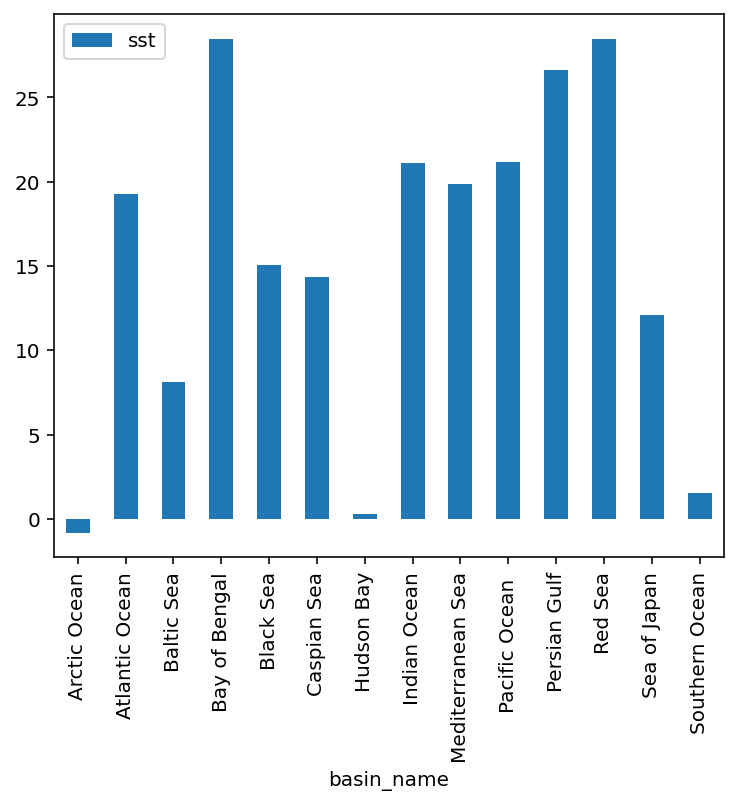

In [40]:
df2.plot.bar(x='basin_name')